In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
np.random.seed(42) # fix randomness

from PTAfast.tensor import Tensor

### Mock data generation

For our mock data, we bury the GWB correlation of fixed amplitude $A_{\rm gwb} = 10^{-15}$ signal in noise.

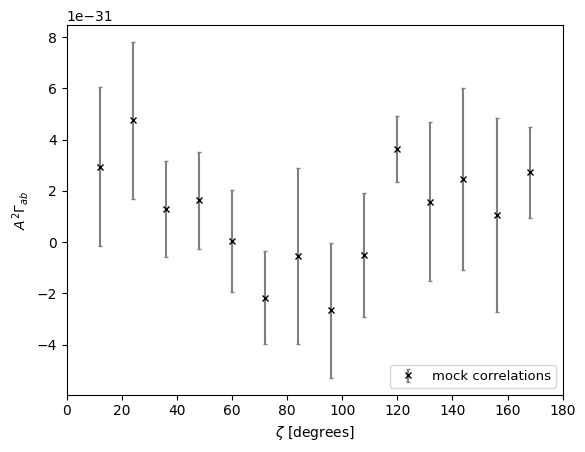

In [2]:
# mock = tensor + uniform noise
lMax =  60
fD = 100
TensorPTAfast = Tensor(lm = lMax, v = 1, fD = fD)

n_tta = 15 # equally spaced points in angle separation
tta = np.linspace(0, np.pi, n_tta + 1)[1:n_tta]
TensorORF = TensorPTAfast.get_ORF(tta)

def mock_orf(r1, r2, sigma, n_outliers=0, mean_offset=0, std_offset=0):
    gwb = TensorORF['ORF']
    ns = np.random.normal(0, sigma, size=len(tta))
    
    # Add non-stationary noise
    f = np.linspace(0, 0.5*fD, len(tta))
    alpha = 1.5
    beta = 2.5
    A = 0.5
    ns *= (f**alpha) / ((f**alpha) \
                        + ((f/beta)**(alpha-1) + 1e-6)) + A*(f/fD)**2
    
    # Add random offset to mean and standard deviation
    offset = np.random.normal(mean_offset, std_offset)
    data = gwb + (r1**2)*(ns + offset) \
    + (r2**2)*np.random.uniform(0, 1, size=len(tta))
    
    # Add outliers
    if n_outliers > 0:
        idx = np.random.choice(len(tta), size=n_outliers, replace=False)
        data[idx] += np.random.normal(0, 1, size=n_outliers)
    
    # Add a small constant value to the noise
    data += 1e-6
    
    return data

# generate mock with unc with 1000 samples
r1_mock = 0.1
r2_mock = 0.1 # uniform noise
sigma_mock = 0.3
N_plsr = 100
N_samp = int(N_plsr*(N_plsr - 1)/2)
data = []
for i in np.arange(0, N_samp):
    data.append(mock_orf(r1 = r1_mock, r2 = r2_mock, \
                         sigma = sigma_mock, n_outliers = 1, \
                         mean_offset = 0.1, std_offset = 0.1)) # adding mean and std offsets
data = np.array(data)

ave_data = []
err_data = []
for i in np.arange(0, len(tta)):
    ave_data.append(np.mean(data[:, i]))
    err_data.append(np.std(data[:, i]))
ave_data = np.array(ave_data)
offsets = np.random.normal(loc=0.0, scale=0.1, size=len(tta))
ave_data += offsets
err_offsets = np.random.normal(loc=0.0, scale=0.1, size=len(tta)) # adding std offsets
err_data = np.array(err_data) + err_offsets # adding std offsets

# plot mock correlations
A_gw = 1e-15

# Add noise to A2_gw
A2_mean = A_gw**2
A2_std = 0.1 * A2_mean
A2_gw = np.random.normal(A2_mean, A2_std, size=len(tta))

# Propagate uncertainty to ccp and Dccp
ccp = A2_gw * ave_data
Dccp = np.sqrt((ave_data**2) * (A2_std**2) + (A2_gw**2) * (err_data**2))

Dccp[Dccp < 0] = 0
# np.savetxt('mock.txt', np.array([tta, ccp, Dccp]))

fig, ax = plt.subplots()
ax.errorbar(tta*180/np.pi, ccp, yerr = Dccp, \
            label = 'mock correlations', \
            fmt = 'kx', markersize = 4, \
            ecolor = 'gray', elinewidth = 1.5, capsize = 1.5)
ax.set_xlim(0, 180)
ax.set_xlabel(r'$\zeta$ [degrees]')
ax.set_ylabel(r'$A^2 \Gamma_{ab}$')
ax.legend(loc = 'lower right', prop = {'size': 9.5})
plt.show()